# Stiffness

We've looked before at the ODE

\begin{align*}
u'(t) & = \lambda (u-\cos(t)) - \sin(t).
\end{align*}

With $u(0)=1$, the solution is just $u(t)=\cos(t)$.

What happens when we integrate this ODE numerically?

Remember that for Euler's method we found the stability function

$$
    R(z) = 1+z,
$$

so we need 

$$|R(z)| = |1 + k\lambda| \le 1,$$

or in other words

$$k \le \frac{2}{|\lambda|}.$$

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import optimize
plt.style.use('seaborn-poster')
matplotlib.rcParams['figure.figsize'] = (10., 6.)

In [2]:
def Euler(u,t,k,f):
    return u + k*f(u,t)

def f(u,t):
    lamda=-10
    return lamda*(u-np.cos(t))-np.sin(t)

def exact_solution(lamda,u,t0=0,T=10):
    t=np.linspace(t0,T,1000)
    u=np.exp(lamda*(t-t0))*(u-np.cos(t0))+np.cos(t)
    return t,u

def plot_Euler(T,k):
    lamda=-10
    u=1.
    n=np.int(np.floor(T/k))
    t,u_ex=exact_solution(lamda,1,0,T=T)
    plt.plot(t,u_ex,'k')

    for i in range(n):
        unew=Euler(u,i*k,k,f)
        plt.plot([i*k,(i+1)*k],[u,unew],'ro-')
        u=unew

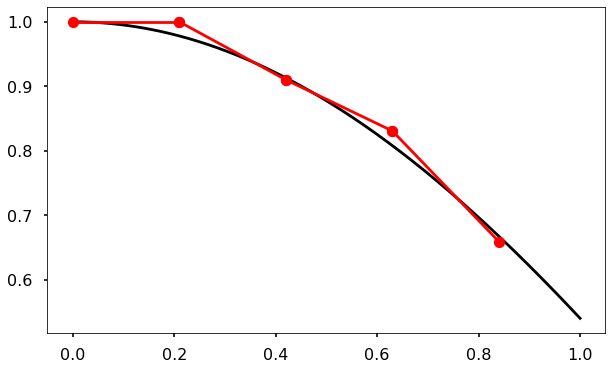

In [3]:
plot_Euler(T=1., k=0.21)

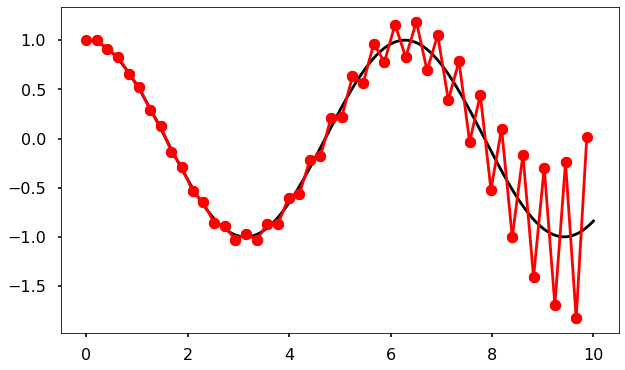

In [4]:
plot_Euler(T=10,k=0.21)

What's going on here?  We know from earlier analysis that because $|k\lambda|>2$ the calculation is unstable, but can we understand the behavior in more detail?

Here are some solutions that start away from the $u(t)=\cos(t)$ trajectory:

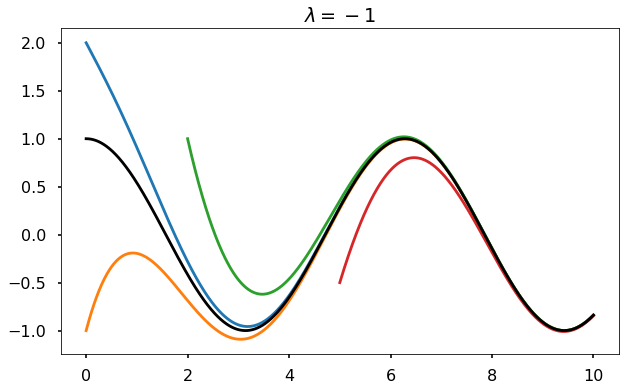

In [5]:
lamda=-1
plt.clf()
for t0,eta in [(0,2),(0,-1),(2,1),(5,-0.5)]:
    t,u=exact_solution(lamda,eta,t0)
    plt.plot(t,u)
t,u=exact_solution(lamda,1,0)
plt.plot(t,u,'k')
plt.title('$\lambda=-1$');

Here's the same but with $\lambda=-10$:

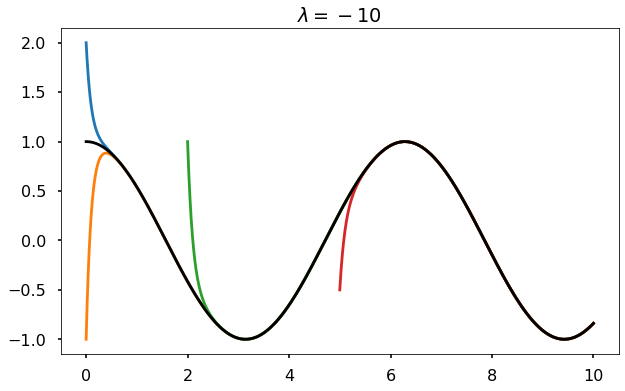

In [6]:
lamda=-10
plt.clf()
for t0,eta in [(0,2),(0,-1),(2,1),(5,-0.5)]:
    t,u=exact_solution(lamda,eta,t0)
    plt.plot(t,u)
t,u=exact_solution(lamda,1,0)
plt.plot(t,u,'k')
plt.title('$\lambda=-10$');

Notice how all solutions very rapidly approach the simple $u(t)=\cos(t)$ solution.  In fact, the general solution is

$$
    u(t) = e^{\lambda(t-t_0)}(u_0-\cos(t_0)) + \cos(t).
$$

We see that the solution $u(t)=\cos(t)$ (and nearby solutions) change **very slowly**, while solutions away from this curve change **very quickly**.  

Even if we start on or near the slowly-varying solution, numerical errors will move us
away from it.  If we try to use a large step, we can end up even further from the slowly-varying solution, and the problem will get worse with each step:

In [7]:
def plot_Euler2(T,k):
    lamda=-10
    u=1.
    n=np.int(np.floor(T/k))
    t,u_ex=exact_solution(lamda,1,0,T=T)
    plt.plot(t,u_ex,'k')

    for i in range(n):
        unew=Euler(u,i*k,k,f)
        plt.plot([i*k,(i+1)*k],[u,unew],'ro-')
        u=unew
        tt,u_ex=exact_solution(lamda,u,(i+1)*k,T=T)
        plt.plot(tt, u_ex)

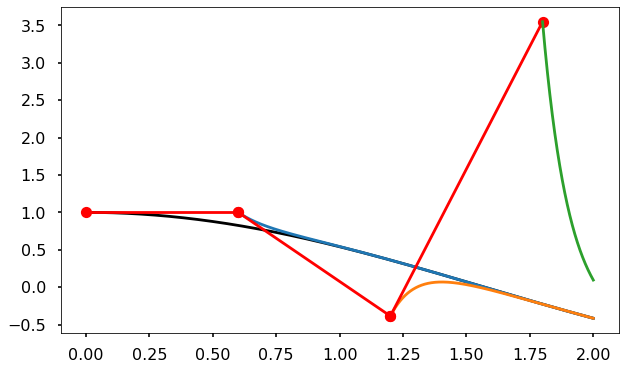

In [8]:
plot_Euler2(2,0.6)

Normally, we expect to get an accurate answer if our time step is inversely proportional to the rate of change of the solution:

$$k \lessapprox \frac{1}{|u'(t)|}.$$

But in this case, even though the exact solution derivative is bounded by one, we find that we have to take $k$ much smaller than one.  In this situation we say the problem is **stiff**.

Note that stiffness doesn't just mean that we need to take "small" time steps.  If the solution were changing rapidly, then we would expect to need small time steps anyway to get an accurate solution.

Here's another example of a stiff problem:

$$\begin{align} 
    u_1'(t) & = -K_1 u_1 \\ 
    u_2'(t) & = K_1 u_1 -K_2 u_2 \\
    u_3'(t) & = K_2 u_2
\end{align}$$  

$$u(0) = [1,0,0].$$  

This corresponds to the decay process

$$A\stackrel{K_1}{\to} B \stackrel{K_2}{\to} C.$$  

We can write this system as

\begin{align*}
    \begin{bmatrix} u_1' \\ u_2' \\ u_3' \end{bmatrix} & = \begin{bmatrix} -K_1 & 0 & 0 \\ K_1 & -K_2 & 0 \\ 0 & K_2 & 0 \end{bmatrix} \begin{bmatrix} u_1 \\ u_2 \\ u_3 \end{bmatrix}
\end{align*}

What are the eigenvalues of the matrix on the right hand side?

$$ \lambda = -K_1, -K_2, 0$$

In [9]:
from scipy.integrate import ode

def reaction(K1=1, K2=2):
    def f(t,u):
        du=np.zeros([3])
        du[0]=-K1*u[0]
        du[1]= K1*u[0] - K2*u[1]
        du[2]=           K2*u[1]
        return du

    t0 = 0.                  # Initial time
    u0 = np.array([1.,0.,0.])# Initial values
    tfinal = 4.              # Final time
    r = ode(f).set_integrator('dopri5',atol=1.e-10,rtol=1.e-10) # Dormand-Prince RK4(5) method
    r.set_initial_value(u0, t0)
    dt_output=0.02           # Interval between output for plotting
    N=int(tfinal/dt_output)       # Number of output times
    tt=np.zeros(N+1); tt[0]=t0  # Output times
    uu=np.zeros([3,N+1]);       # Output values
    uu[:,0]=u0
    i=0
    while r.successful() and r.t<tfinal:
        i=i+1
        uu[:,i]=r.integrate(r.t+dt_output)
        tt[i]=r.t
        
    plt.plot(tt,uu[0,:],tt,uu[1,:],tt,uu[2,:]);
    plt.legend(['A','B','C']);

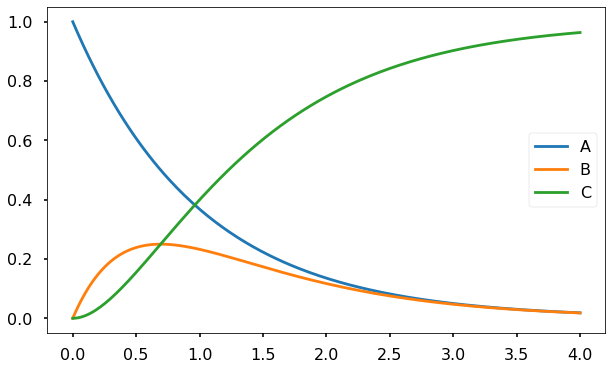

In [10]:
reaction(K1=1,K2=2)

Now let's try it with one fast reaction and one slow reaction:

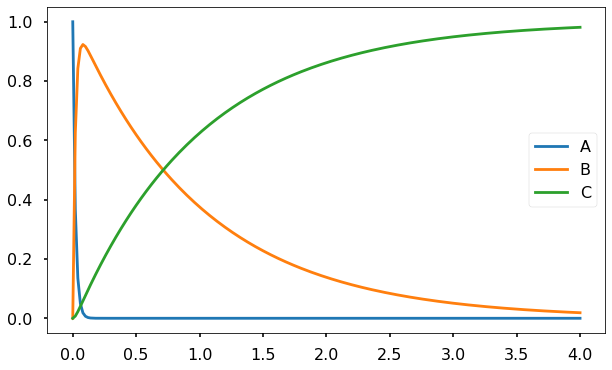

In [11]:
reaction(K1=50,K2=1)

What's happening in this solution?  Is the problem stiff?

If we use an explicit method to solve a stiff problem, we will need a **very small timestep** in order to keep the computation stable, even though we don't need a very small timestep to make the local truncation error small.

Because of this, it's much better to use an **implicit method** with good stability properties.  Then we can choose a step size that gives an appropriate size of error, without worrying about stability.

# A practical definition of stiffness

A problem is stiff if it can be solved more efficiently with an implicit method than an explicit method.

## A-stability

We say a method is **A-stable** if the entire left half of the complex plane is contained in its stability region:

$$
Re(\lambda)\le 0 \implies |R(k\lambda)|\le 1.
$$

We already saw that the backward Euler method and the implicit trapezoidal method are A-stable.  There exist Runge-Kutta methods of arbitrarily high order that are A-stable.

However, linear multistep methods that are A-stable cannot be more than 2nd order accurate (Dahlquist's barrier).

## A$(\alpha)$-stability

For the two examples we looked at earlier, $\lambda$ is real.  So we don't need stability in the whole left half-plane, but only on the whole negative real axis.  Some methods that are not $A$-stable will still work well here.

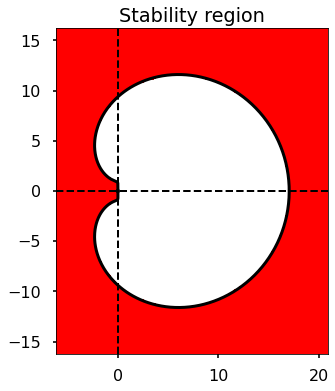

In [95]:
from nodepy import lm
bdf5= lm.backward_difference_formula(5)
bdf5.plot_stability_region();

We say a method is **A$(\alpha)$-stable** for a given angle $\alpha$ if it is stable for a wedge (extending to infinity) that makes an angle $\alpha$ with the negative real axis.  A-stability corresponds to $\alpha=90$ degrees.

## L-stability

What about **extremely stiff** problems?  For the test problem

$$ u'(t) = \lambda u(t)$$

we have

$$u(t_{n+1}) = e^{\lambda k}u(t_n)$$

If we let $z=\lambda k \to -\infty$, we have $e^z \to 0$.
In other words, solution components that are extremely stiff should vanish quickly.
With a numerical method we have

$$U^{n+1} = R(z) U^n$$

so we ought to have $R(z)\to 0$ as $z \to -\infty$.

For backward Euler:

$$
\lim_{z\to-\infty} R(z) = \lim_{z\to-\infty} \frac{1}{1-z} = 0.
$$

But for the implicit trapezoidal method:

$$
\lim_{z\to-\infty} R(z) = \lim_{z\to-\infty} \frac{1+z/2}{1-z/2} = -1.
$$

We say backward Euler is **L-stable** while the trapezoidal method is not.  Methods that are not L-stable have trouble with extremely stiff problems.

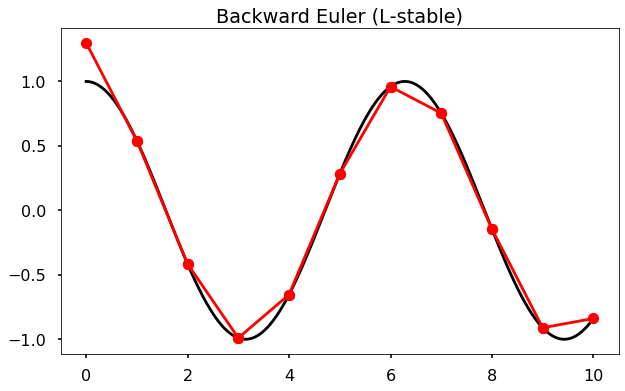

In [105]:
lam = -1e3
def f(u,t):
    lamda=lam
    return lamda*(u-np.cos(t))-np.sin(t)

def Backward_Euler(u,t,k,f):
    obj = lambda unew : unew - k*f(unew,t+k) - u
    unew = optimize.fsolve(obj,u)
    return unew

def plot_backward_Euler(T,k):
    lamda=lam
    u=1.3
    n=np.int(np.floor(T/k))
    t,u_ex=exact_solution(lamda,1,0,T=T)
    plt.plot(t,u_ex,'k')

    for i in range(n):
        unew=Backward_Euler(u,i*k,k,f)
        plt.plot([i*k,(i+1)*k],[u,unew],'ro-')
        u=unew

plot_backward_Euler(T=10., k=1.)
plt.title('Backward Euler (L-stable)');

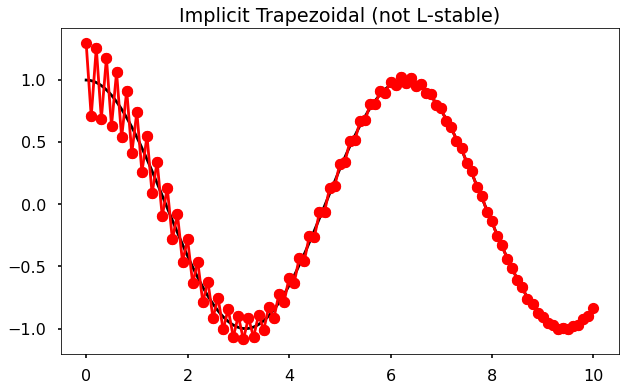

In [106]:
def Implicit_trapezoidal(u,t,k,f):
    obj = lambda unew : unew - 0.5*k*(f(u,t)+f(unew,t+k)) - u
    unew = optimize.fsolve(obj,u)
    return unew

def plot_IT(T,k):
    lamda=lam
    u=1.3
    n=np.int(np.floor(T/k))
    t,u_ex=exact_solution(lamda,1,0,T=T)
    plt.plot(t,u_ex,'k')

    for i in range(n):
        unew=Implicit_trapezoidal(u,i*k,k,f)
        plt.plot([i*k,(i+1)*k],[u,unew],'ro-')
        u=unew

plot_IT(T=10., k=.1)
plt.title('Implicit Trapezoidal (not L-stable)');

## Backward differentiation formulas

This is a family of 6 linear multistep methods that are $A(\alpha)$-stable and L-stable.  They take the form:

$$
\sum_{j=0}^r \alpha_j U^{n+j} = k \beta f(U^{n+r}).
$$

For $r=1$, we just have the backward Euler method.  For $r>6$ the methods are not zero-stable.

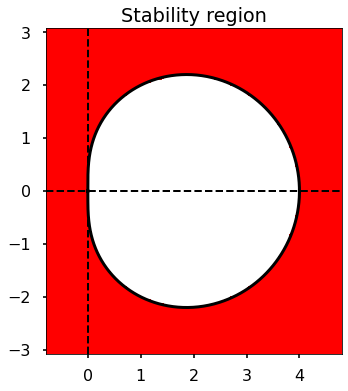

In [98]:
bdf2= lm.backward_difference_formula(2)
bdf2.plot_stability_region();

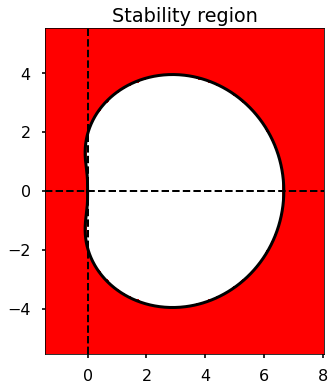

In [99]:
bdf3= lm.backward_difference_formula(3)
bdf3.plot_stability_region();

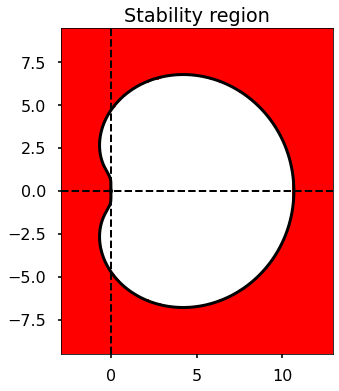

In [100]:
bdf4= lm.backward_difference_formula(4)
bdf4.plot_stability_region();

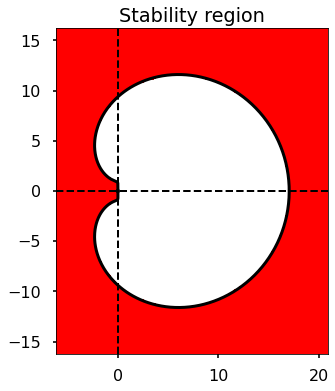

In [101]:
bdf5= lm.backward_difference_formula(5)
bdf5.plot_stability_region();

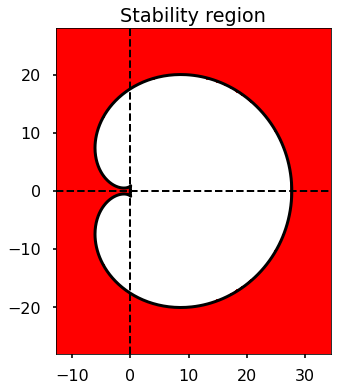

In [102]:
bdf6= lm.backward_difference_formula(6)
bdf6.plot_stability_region();

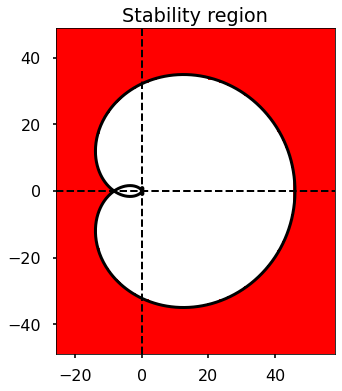

In [53]:
from nodepy import lm
bdf6= lm.backward_diffe3rence_formula(7)
bdf6.plot_stability_region();